In [1]:
import os
import logging, timeit
from btEngine2.DataLoader import DataLoader
from btEngine2.MarketData import MarketData
from btEngine2.TradingRule import TradingRule



# Define paths and configurations for DataLoader
ticker_csv_path = r'G:\Projects\BackTesting1.0\Data\Inputs\TickerList-Futs.csv'
save_directory = r"G:\Projects\BackTesting1.0\Data\Bloomberg\Futures"
helper_directory = r'G:\Projects\BackTesting1.0\Data\Bloomberg\HelperFiles'

bt_folder = r'BackTests\ratioRSI_resrch'

# Define paths to auxiliary data for MarketData
tick_values_path = os.path.join(helper_directory, 'fut_val_pt.parquet')
fx_rates_path = os.path.join(helper_directory, 'fxHist.parquet')

# Initialize the MarketData
market_data = MarketData(
    base_directory=save_directory,
    tick_values_path=tick_values_path,
    fx_rates_path=fx_rates_path,
    instrument_type="Futures",
    n_threads=8,  # Number of threads for parallel data loading
    log_level=logging.ERROR  # Set to DEBUG for more detailed logs
)


In [2]:
tick = 'XTD1 Curncy'
# Access data for a specific ticker
try:
    test_df = market_data.get_ticker_data(tick)
    print(test_df)
except ValueError as e:
    print(e)

# Access all preprocessed data
all_data = market_data.get_data()
print(f"Total tickers loaded: {len(all_data)}")

# Access FX rates
fx_rates = market_data.get_fx_rates()
# Access tick values
tick_values = market_data.get_tick_values()
# Access asset classes
asset_classes = market_data.get_asset_classes()

#market_data = market_data.date_filter(start_date='01012010')

shape: (2_378, 14)
┌────────────┬────────┬────────┬────────┬───┬─────────┬─────────┬─────────────────┬────────────────┐
│ Date       ┆ Open   ┆ High   ┆ Low    ┆ … ┆ BadOHLC ┆ FX_Rate ┆ Tick_Value_Base ┆ Tick_Value_USD │
│ ---        ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---     ┆ ---     ┆ ---             ┆ ---            │
│ date       ┆ f64    ┆ f64    ┆ f64    ┆   ┆ bool    ┆ f64     ┆ f64             ┆ f64            │
╞════════════╪════════╪════════╪════════╪═══╪═════════╪═════════╪═════════════════╪════════════════╡
│ 2015-09-01 ┆ null   ┆ null   ┆ null   ┆ … ┆ false   ┆ 1.0     ┆ 100000.0        ┆ 100000.0       │
│ 2015-09-02 ┆ null   ┆ null   ┆ null   ┆ … ┆ false   ┆ 1.0     ┆ 100000.0        ┆ 100000.0       │
│ 2015-09-03 ┆ null   ┆ null   ┆ null   ┆ … ┆ false   ┆ 1.0     ┆ 100000.0        ┆ 100000.0       │
│ 2015-09-04 ┆ null   ┆ null   ┆ null   ┆ … ┆ false   ┆ 1.0     ┆ 100000.0        ┆ 100000.0       │
│ 2015-09-07 ┆ null   ┆ null   ┆ null   ┆ … ┆ false   ┆ 1.0     ┆ 100000

In [3]:

pSizeParams = {
    'AssetVol': 5_000_000,  # Target asset volatility in USD
    'VolLookBack': (30, 252, 0.7),
    'VolMethod': 'ewm'  # Lookback period for volatility calculation
}


In [4]:
from btEngine2.Rules.MeanReversion.ratioMR import *

fi_asst = 'WN1 Comdty'
# Define the list of asset pairs you want to trade
pairs = [
    ('NQ1 Index', fi_asst),
    (fi_asst, 'NQ1 Index')
]
    
strategy_params2 = {
    'pairs': pairs,
    'N': 5,
    'rsi_period': 3,
    'rsi_threshold': 10.0,
    'market_data': market_data,  # Pass the MarketData instance
}

   
strategy_params_short = {
    'pairs': pairs,
    'N': 5,
    'rsi_period': 3,
    'rsi_threshold': 10.0,
    'market_data': market_data,  # Pass the MarketData instance
}
# Set strategy parameters
strategy_params = {
    'pairs': pairs,
    'N': 5,
    'rsi_period': 3,
    'rsi_threshold': 10.0,
    'lmt_order': True,
    'lmt_day': 2,
    'lmt_day_only': False,
    'lmt_atr': 1,
    'lmt_epsilon': 0.1,
    'atr_period': 5,
    'atr_type': 'atr',
    'market_data': market_data  # Pass the MarketData instance
}

strategy_params3 = strategy_params2.copy()
strategy_params3['trend_filter'] = 120

strategy_params4 = strategy_params2.copy()
strategy_params4['oversold_cond'] = True

strategy_params5 = strategy_params3.copy()
strategy_params5['oversold_cond'] = True


In [17]:
### Where the magic happens

asst_main = 'NQ1 Index'

cmp_assts = market_data.get_asset_classes()['eq-us']
cmp_assts
cmp_assts = ['US1 Comdty', 'WN1 Comdty']


respnls = {}
results = {}
statsdf = {}
trules = {}

for asst in cmp_assts:
    
    pairs = [
        (asst_main, asst),
        (asst, asst_main)
    ]
    
    strategy_params2 = {
        'pairs': pairs,
        'N': (5, 2),
        'rsi_period': (3,3),
        'rsi_threshold': (10.0,8.0),
        'lmt_order': False,
        'lmt_day': 1,
        'lmt_day_only': True,
        'lmt_atr': -0.25,
        'lmt_epsilon': 0.1,
        'atr_period': 3,
        'atr_type': 'atr',
        'market_data': market_data,
        'risk_ratio': (1.0, 1.1)
        
    }

    tmp = TradingRule(
        market_data=market_data,
        trading_rule_function=ratioMR_rsi_long,
        trading_params=strategy_params2,
        position_sizing_params=pSizeParams,  # Define as needed
        incl_assets=[asst_main, asst],  # Include all involved assets
        name_label='TestMR_' + asst,
        strat_descr= f'rsi mr strategy {asst_main} vs. {asst}',
        log_level=logging.INFO,
        bt_folder = bt_folder
    )

    res = tmp.backtest_all_assets(save=True)
    resdb = tmp.plot_equity(byassets=True, totalsys=True, start_date = '01012000', save_fig=True)
    stats = tmp.calculate_statistics(byassets=True, totalsys=True, start_date='01012000')
    statsdf[asst] = stats
    results[asst] = resdb
    respnls[asst] = res
    trules[asst] = tmp

# Extract the desired statistics from each dataframe in statsdf

required_columns = ['Average Ann. PnL', 'Average Ann. Vol', 'Sharpe Ratio (ann.)', 'Sortino Ratio (ann.)', 'Hit Rate (%)', 'Profit Factor', 
                    'Max drawdown', 'Average drawdown', 'Avg Drawdown Duration', 'Drawdowns per year', 'Max Drawdown Duration']
extracted_stats = {key: statsdf[key].loc['Total', [col for col in required_columns if col in statsdf[key].columns]] for key in statsdf.keys()}

# Convert the dictionary to a dataframe
extracted_stats_df = pd.DataFrame.from_dict(extracted_stats, orient='index')
extracted_stats_df.to_clipboard()
extracted_stats_df

2024-10-24 10:32:12,966 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Initialized TradingRule for function 'ratioMR_rsi_long' with params hash 'c40129997d'
2024-10-24 10:32:12,967 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Using scalar AssetVol: 5000000 for all assets.
2024-10-24 10:32:12,967 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Starting backtest on all assets.
2024-10-24 10:32:12,968 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Backtesting asset 'NQ1 Index'
2024-10-24 10:32:12,968 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Backtesting asset 'NQ1 Index'
2024-10-24 10:32:13,068 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Blended volatility: lb_fast=30, lb_slow=252, lb_ratio=0.7
2024-10-24 10:32:13,171 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Backtest data for asset 'NQ1 Index' saved to 'BackTests\ratioRSI_resrch\ratioMR_rsi_long_c40129997d_2c227aeee1_TestMR_US1 Comdty\backtest_results\NQ1 Index_backtest.parquet'
2024-10-24 10:32:

2024-10-24 10:32:13,974 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Figure saved as 'BackTests\ratioRSI_resrch\ratioMR_rsi_long_c40129997d_2c227aeee1_TestMR_US1 Comdty\ratioMR_rsi_long_c40129997d_2c227aeee1_TestMR_US1 Comdty_equity_curve_24102024-103213.html'
2024-10-24 10:32:13,976 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Loading backtest results from saved parquet files.
2024-10-24 10:32:14,003 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Generated cumulative PnL DataFrame by assets.
2024-10-24 10:32:14,007 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Calculating trade statistics using actual trades.
2024-10-24 10:32:14,247 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Calculating trade statistics using actual trades.
2024-10-24 10:32:14,441 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Calculating trade statistics using actual trades.
2024-10-24 10:32:14,622 - TradingRule_ratioMR_rsi_long_c40129997d - INFO - Strategy stats calculation complete.

2024-10-24 10:32:15,359 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Figure saved as 'BackTests\ratioRSI_resrch\ratioMR_rsi_long_e62d041d18_2c227aeee1_TestMR_WN1 Comdty\ratioMR_rsi_long_e62d041d18_2c227aeee1_TestMR_WN1 Comdty_equity_curve_24102024-103215.html'
2024-10-24 10:32:15,361 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Loading backtest results from saved parquet files.
2024-10-24 10:32:15,373 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Generated cumulative PnL DataFrame by assets.
2024-10-24 10:32:15,375 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Calculating trade statistics using actual trades.
2024-10-24 10:32:15,481 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Calculating trade statistics using actual trades.
2024-10-24 10:32:15,589 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Calculating trade statistics using actual trades.
2024-10-24 10:32:15,697 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Strategy stats calculation complete.

,Average Ann. PnL,Average Ann. Vol,Sharpe Ratio (ann.),Sortino Ratio (ann.),Hit Rate (%),Profit Factor,Max drawdown,Average drawdown,Avg Drawdown Duration,Drawdowns per year
US1 Comdty,2.595053e+06,3.174467e+06,0.817477,0.641097,59.554140,1.396625,7168262.500,1.566121e+06,38.284672,5.469582
WN1 Comdty,4.190339e+06,3.077928e+06,1.361416,0.993030,64.044944,1.760294,3764328.125,9.154484e+05,24.081818,7.439614


In [6]:
statsdf['US1 Comdty']

,Total PnL,Average Ann. PnL,Average Ann. Vol,Sharpe Ratio (ann.),Sortino Ratio (ann.),Max drawdown,Average drawdown,Max drawdown Duration,Avg Drawdown Duration,Total Number of Drawdowns,...,Daily Left Tail,Daily Right Tail,Weekly Left Tail,Weekly Right Tail,Monthly Left Tail,Monthly Right Tail,Quarterly Left Tail,Quarterly Right Tail,Yearly Left Tail,Yearly Right Tail
Column,,,,,,,,,,,,,,,,,,,,,
NQ1 Index,1.927204e+07,4.007059e+06,2.501291e+06,1.601996,0.921911,3258700.000,476048.413838,114,18.238095,42,...,5.938626,-8.677787,2.627571,-4.615274,1.370773,1.137276,1.715163,0.875795,1.490592,1.545079
US1 Comdty,3.017816e+06,6.274666e+05,1.718182e+06,0.365192,0.199918,2197387.500,939592.905668,343,120.750000,8,...,40.647915,-38.519270,14.211492,-11.341915,1.221396,1.027873,0.627478,1.215397,0.488712,0.641016
Total,2.228986e+07,4.634525e+06,3.030720e+06,1.529183,1.180180,2971565.625,675308.382267,181,17.551020,49,...,7.460228,-8.198472,2.387936,1.168221,1.292829,0.833463,1.249623,1.188683,0.849517,0.852022


In [7]:
respnls['US1 Comdty'][0]['US1 Comdty'].to_clipboard()

In [8]:
nq_pl = market_data.get_ticker_data('WN1 Comdty')
nq = nq_pl.to_pandas() 
nq.set_index('Date', inplace=True)

In [9]:
import plotly.graph_objects as go

# Extract the OHLC data for 'NQ1 Index'
nq_data = nq[['Open', 'High', 'Low', 'Close']]

# Create the OHLC plot
fig = go.Figure(data=[go.Ohlc(
    x=nq_data.index,
    open=nq_data['Open'],
    high=nq_data['High'],
    low=nq_data['Low'],
    close=nq_data['Close'],
    name='NQ1 Index'
)])

# Update layout for better visualization
fig.update_layout(
    title='NQ1 Index OHLC Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False
)

# Show the plot
fig.show()

In [10]:
mthlypnl = trules['WN1 Comdty'].monthly_pnl(filter_assets=['WN1 Comdty'],save=True, name='WN monthlypnl.csv')
mthlypnl = trules['WN1 Comdty'].monthly_pnl(filter_assets=['NQ1 Index'],save=True, name='NQ monthlypnl.csv')
mthlypnl = trules['WN1 Comdty'].monthly_pnl(save=True, name='Strategy monthlypnl.csv')

2024-10-24 10:31:55,801 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Loading backtest results from saved parquet files.
2024-10-24 10:31:55,814 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Generated cumulative PnL DataFrame by assets.
2024-10-24 10:31:55,838 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Monthly PnLs saved to 'BackTests\ratioRSI_resrch\ratioMR_rsi_long_e62d041d18_2c227aeee1_TestMR_WN1 Comdty\WN monthlypnl.csv'
2024-10-24 10:31:55,840 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - README.txt created at BackTests\ratioRSI_resrch\ratioMR_rsi_long_e62d041d18_2c227aeee1_TestMR_WN1 Comdty\README.txt
2024-10-24 10:31:55,841 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Monthly PnL calculation complete.
2024-10-24 10:31:55,842 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Loading backtest results from saved parquet files.
2024-10-24 10:31:55,851 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Generated cumulative PnL DataFrame by assets.
2024-1

In [11]:
mthlypnl

,1,2,3,4,5,6,7,8,9,10,11,12,Annual_PnL,Sharpe_Ratio,Annual_Vol,Hit_Rate,Profit_Factor,Worst_Drawdown
Year,,,,,,,,,,,,,,,,,,
2010,103277.500,405490.000,366874.375,776031.250,-512952.500,-478013.750,1327383.125,-382240.000,1107763.750,-372980.625,752175.000,1210323.125,4303131.250,1.518900,2.914001e+06,0.628571,1.602543,-1801221.250
2011,931560.625,883747.500,517776.250,-257454.375,725365.000,1376446.250,905033.750,-1821422.500,403031.875,758172.500,-38110.000,-177216.875,4206930.000,1.265396,3.324595e+06,0.597561,1.501869,-2575420.000
2012,139115.625,982861.250,1289386.875,1363177.500,-1263425.000,497766.875,689080.625,262818.750,-516111.250,-313800.000,-184620.000,-1522350.000,1423901.250,0.459100,3.089244e+06,0.522222,1.139604,-3364136.250
2013,675878.125,498950.000,-294816.875,921913.125,-39668.750,662348.125,919497.500,798450.000,426904.375,686918.125,735512.500,16863.750,6008750.000,2.692340,2.231795e+06,0.720588,2.415042,-681896.875
2014,1647110.000,37125.000,99276.875,131986.875,-285904.375,844130.625,1733680.625,1271095.000,1153191.250,-483431.250,369290.625,259528.125,6777079.375,2.320998,2.919898e+06,0.618421,2.082683,-1272955.625
2015,-1759838.125,-799761.250,429258.750,384393.125,826010.000,1020211.875,-559354.375,320230.625,666215.000,513763.750,98835.000,766588.750,1906553.125,0.599893,3.165596e+06,0.554217,1.192954,-2333535.625
2016,-292685.000,785264.375,769820.625,338181.250,-6344.375,367316.250,183425.000,629452.500,666610.000,-51476.875,79822.500,-200722.500,3268663.750,1.042162,3.136426e+06,0.530303,1.450032,-1469530.000
2017,1150787.500,669446.875,298201.250,470500.000,727353.750,657940.000,165859.375,2139064.375,1230867.500,639478.125,67036.250,514135.625,8730670.625,3.161987,2.772134e+06,0.690141,2.842157,-964734.375
2018,-226261.250,287178.125,425048.125,853041.250,-44660.625,112778.750,451093.125,1407613.125,115603.125,-1793407.500,-79189.375,-232688.750,1276148.125,0.328049,3.890118e+06,0.551724,1.106157,-3140053.125


In [12]:
statsdf = trules['WN1 Comdty'].calculate_statistics(byac=True, totalsys=True, start_date='01012000', save=True)

2024-10-24 10:31:55,951 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Loading backtest results from saved parquet files.
2024-10-24 10:31:55,966 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Generated cumulative PnL DataFrame by asset class.
2024-10-24 10:31:55,969 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Calculating trade statistics using actual trades.
2024-10-24 10:31:55,971 - TradingRule_ratioMR_rsi_long_e62d041d18 - WARNING - No trades found for asset 'eq-us'.
2024-10-24 10:31:56,086 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Calculating trade statistics using actual trades.
2024-10-24 10:31:56,087 - TradingRule_ratioMR_rsi_long_e62d041d18 - WARNING - No trades found for asset 'fi-us'.
2024-10-24 10:31:56,198 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Calculating trade statistics using actual trades.
2024-10-24 10:31:56,315 - TradingRule_ratioMR_rsi_long_e62d041d18 - INFO - Strategy stats saved to 'BackTests\ratioRSI_resrch\ratioMR_rsi_long_e62d

In [13]:
statsdf

,Total PnL,Average Ann. PnL,Average Ann. Vol,Sharpe Ratio (ann.),Sortino Ratio (ann.),Max drawdown,Average drawdown,Max drawdown Duration,Avg Drawdown Duration,Total Number of Drawdowns,...,Total PnL Losers,Profit Factor,PnL Skew,Trade EV,Best Trade,Worst Trade,25p Trade,50p Trade,75p Trade,Pareto Number (%)
Column,,,,,,,,,,,,,,,,,,,,,
eq-us,43112925.0,2.915850e+06,2.566838e+06,1.135969,0.611873,6972960.000,1.267799e+06,738,34.618421,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fi-us,18844237.5,1.274489e+06,1.704427e+06,0.747753,0.405792,2818818.750,9.604242e+05,717,70.950000,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total,61957162.5,4.190339e+06,3.077928e+06,1.361416,0.993030,3764328.125,9.154484e+05,295,24.081818,110,...,-79237867.5,1.760294,-0.902004,84612.429775,1183000.0,-1851470.0,-115831.25,127890.625,330826.25,9.831461


In [14]:
trades_list = trules['US1 Comdty'].tradeslist

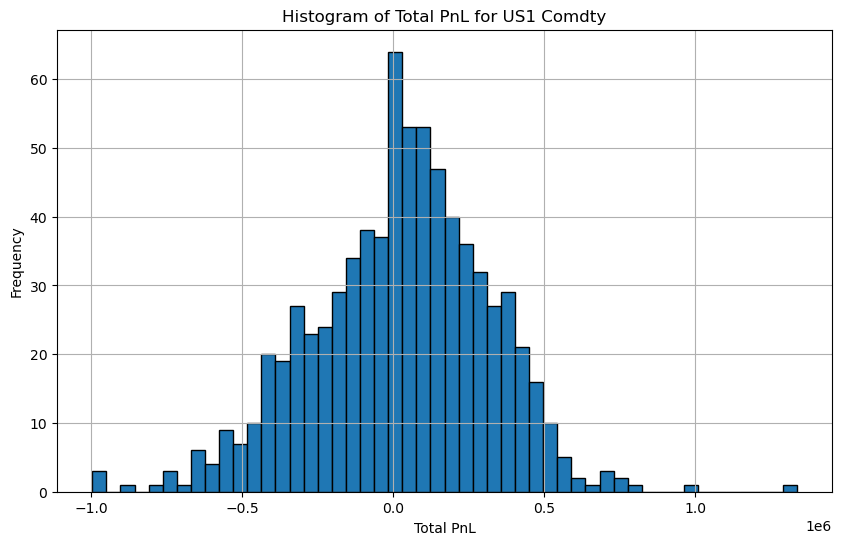

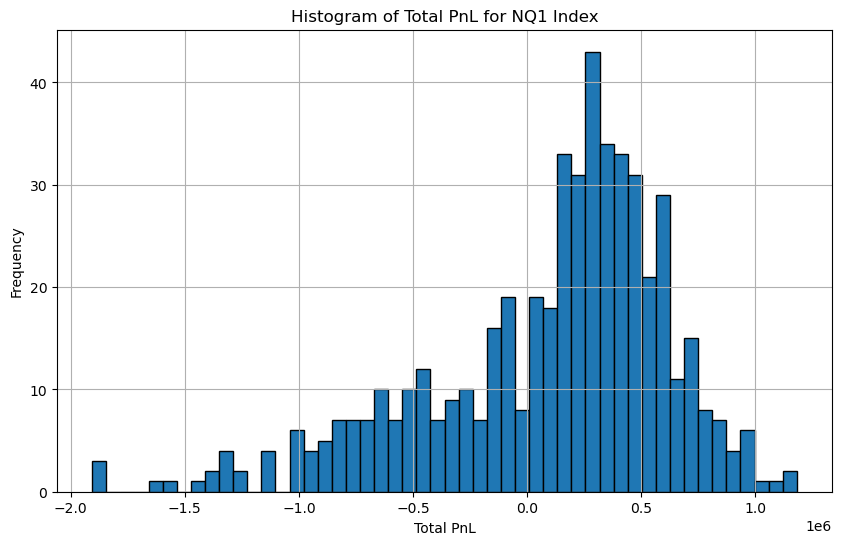

In [15]:
trades_list
import matplotlib.pyplot as plt
# Get unique assets from the trades list
unique_assets = trades_list['Asset'].unique()

# Plot histogram for each unique asset
for asset in unique_assets:
    asset_trades = trades_list[trades_list['Asset'] == asset]
    plt.figure(figsize=(10, 6))
    plt.hist(asset_trades['Total PnL'], bins=50, edgecolor='black')
    plt.title(f'Histogram of Total PnL for {asset}')
    plt.xlabel('Total PnL')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


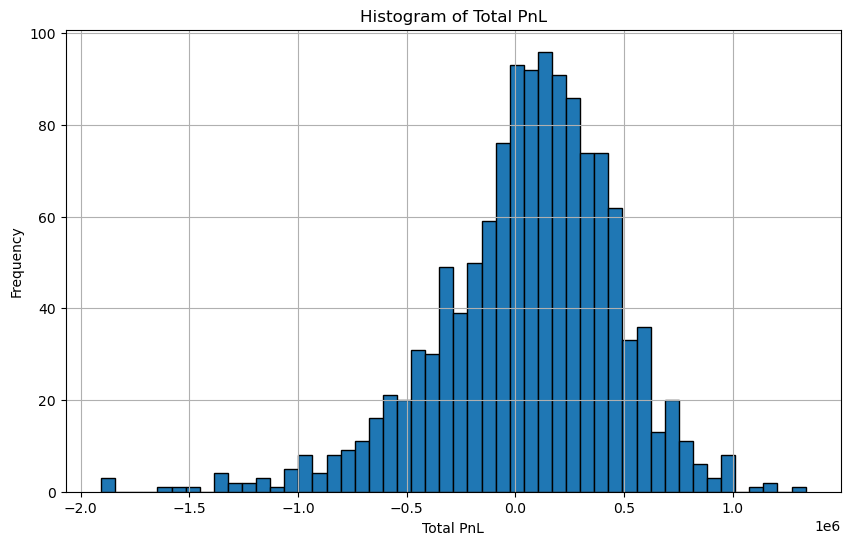

In [16]:
# Plot histogram of 'Total PnL' column
plt.figure(figsize=(10, 6))
plt.hist(trades_list['Total PnL'], bins=50, edgecolor='black')
plt.title('Histogram of Total PnL')
plt.xlabel('Total PnL')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()